## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [23]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [24]:
# Random state seed
rseed = 42

## Load and explore data

In [25]:
country_df = pd.read_csv('Country-data.csv')

In [26]:
# Check the shape
country_df.shape

(167, 10)

In [27]:
# Check datatypes & counts

country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [28]:
country_df.describe

<bound method NDFrame.describe of                  country  child_mort  exports  health  imports  income  \
0            Afghanistan        90.2     10.0    7.58     44.9    1610   
1                Albania        16.6     28.0    6.55     48.6    9930   
2                Algeria        27.3     38.4    4.17     31.4   12900   
3                 Angola       119.0     62.3    2.85     42.9    5900   
4    Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   
..                   ...         ...      ...     ...      ...     ...   
162              Vanuatu        29.2     46.6    5.25     52.7    2950   
163            Venezuela        17.1     28.5    4.91     17.6   16500   
164              Vietnam        23.3     72.0    6.84     80.2    4490   
165                Yemen        56.3     30.0    5.18     34.4    4480   
166               Zambia        83.1     37.0    5.89     30.9    3280   

     inflation  life_expec  total_fer   gdpp  
0         9.44        56.2    

In [29]:
country_df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

## Preprocessing and Feature Selection

In [30]:
country_df.head()
country_df.drop(['country'], axis=1, inplace=True)
country_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


<Axes: >

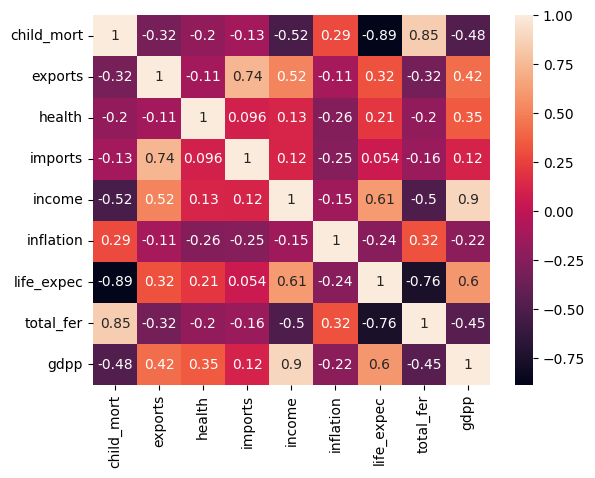

In [31]:
# Create a correlation map of features to explore relationships between features
# Hint: Explore seaborn heatmap

corr = country_df.corr()

# plot the heatmap
sns.heatmap(corr, annot=True)

There is a strong relationship between gdpp and income, as well as a strong relationship between child mortality and total fertility.

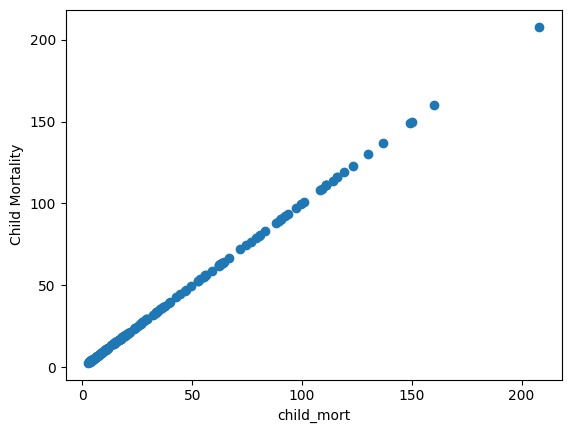

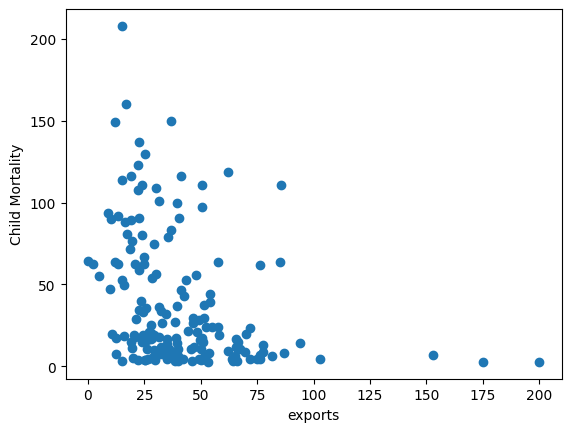

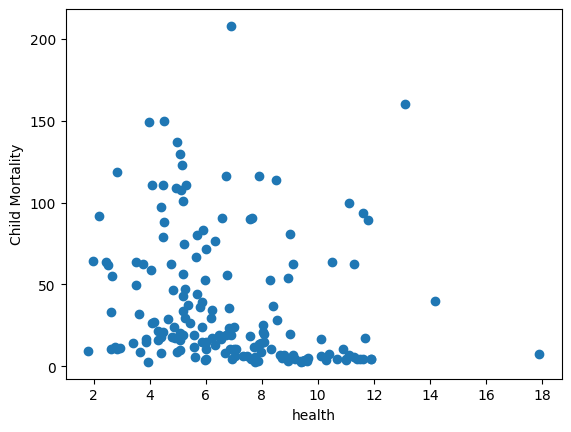

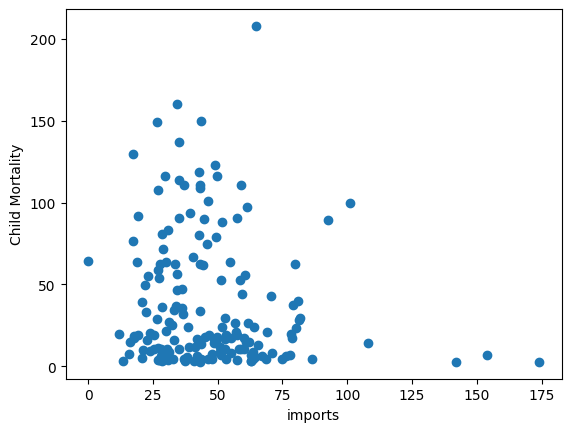

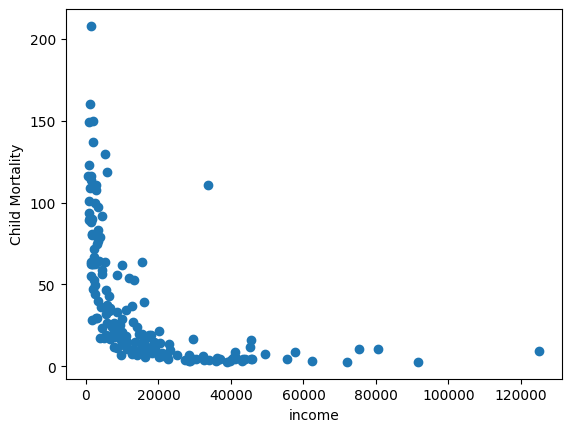

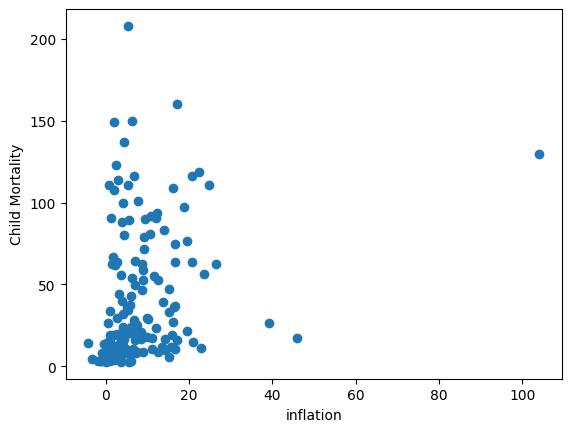

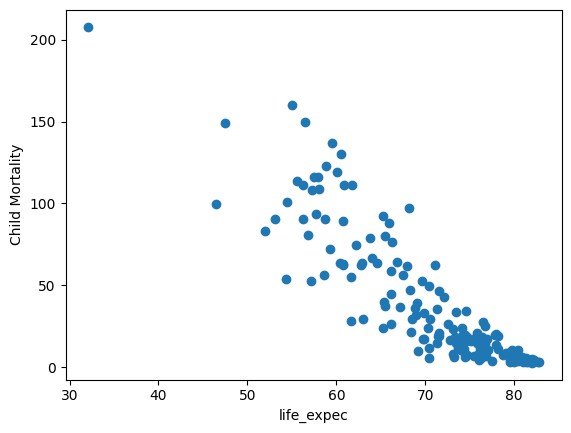

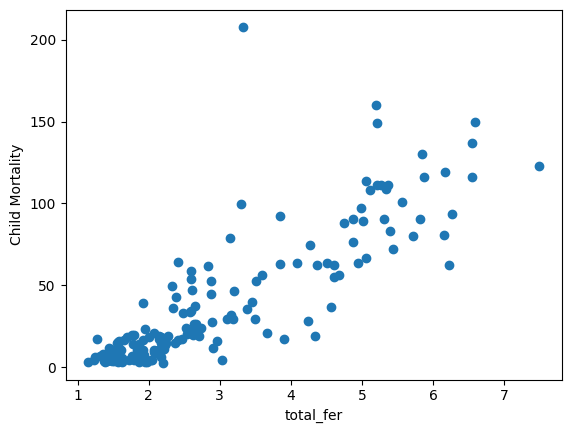

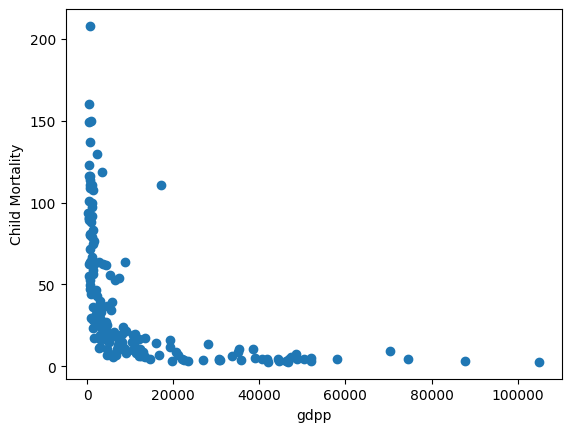

In [32]:
# Explore the continuous independent features against child_mort using scatter plots.
for f in country_df.columns[0:9]:
  plt.scatter(country_df[f], country_df['child_mort'])
  plt.xlabel(f)
  plt.ylabel('Child Mortality')
  plt.show()

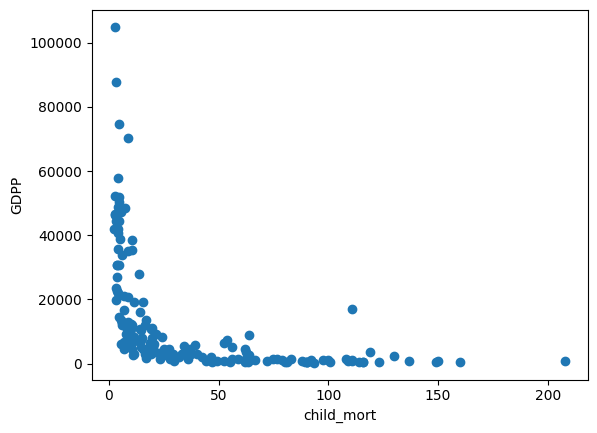

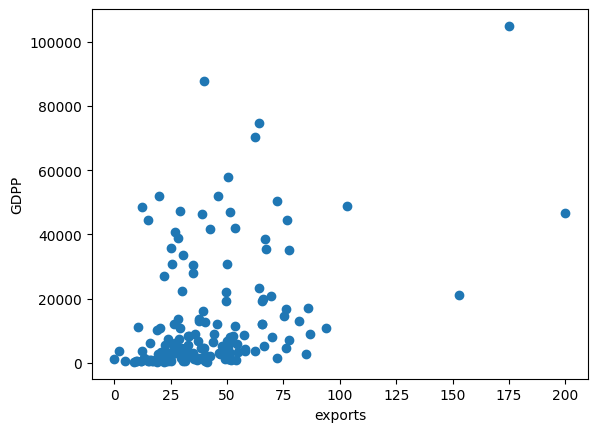

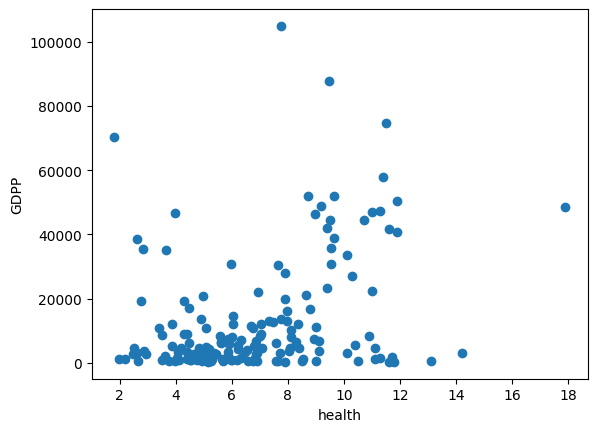

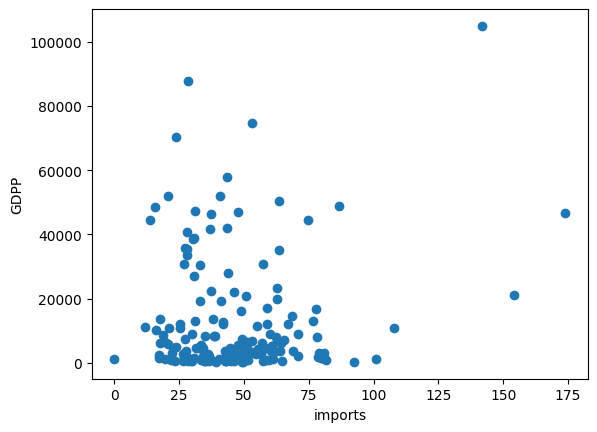

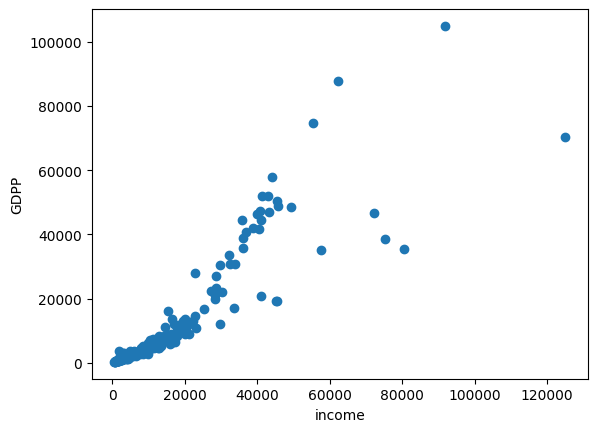

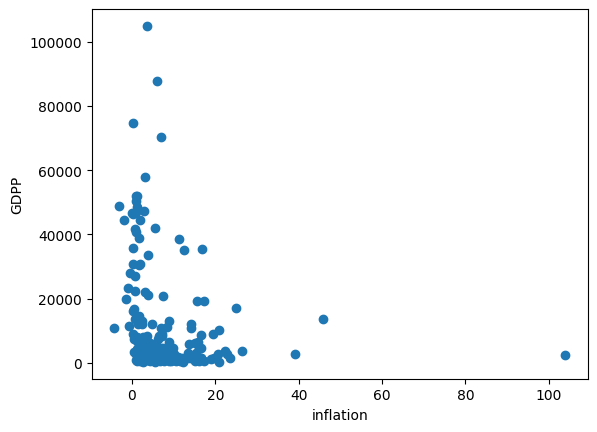

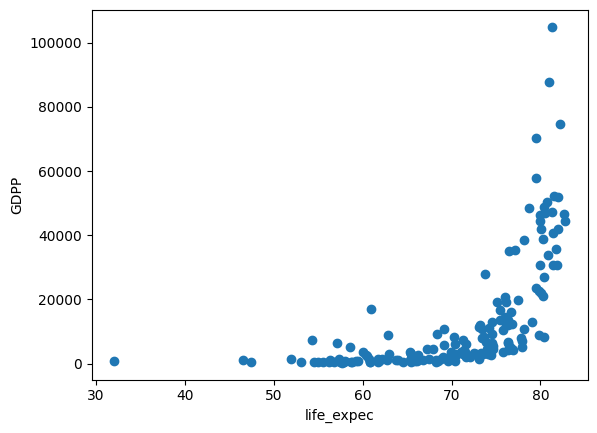

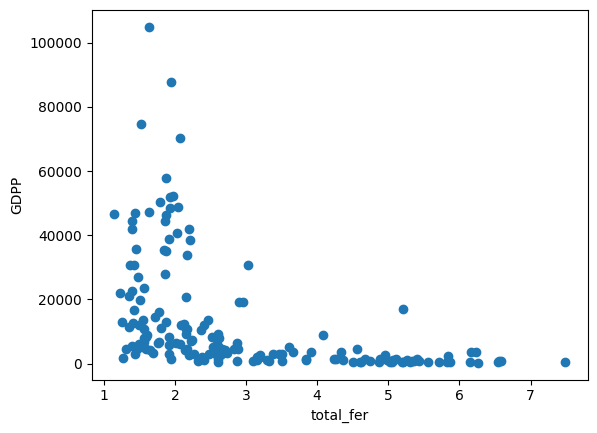

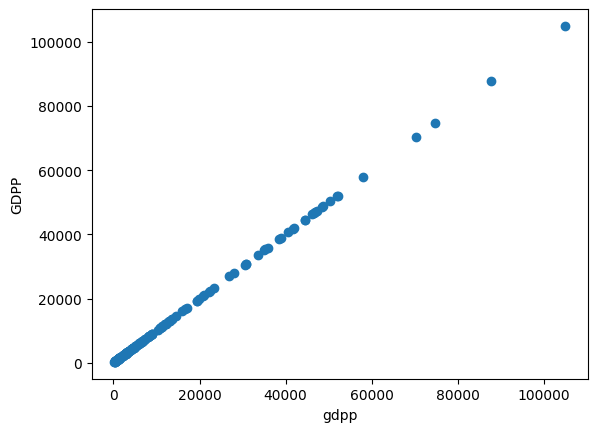

In [33]:
# Explore the continuous independent features against gdpp using scatter plots.
for f in country_df.columns[0:9]:
    plt.scatter(country_df[f], country_df['gdpp'])
    plt.xlabel(f)
    plt.ylabel('GDPP')
    plt.show()

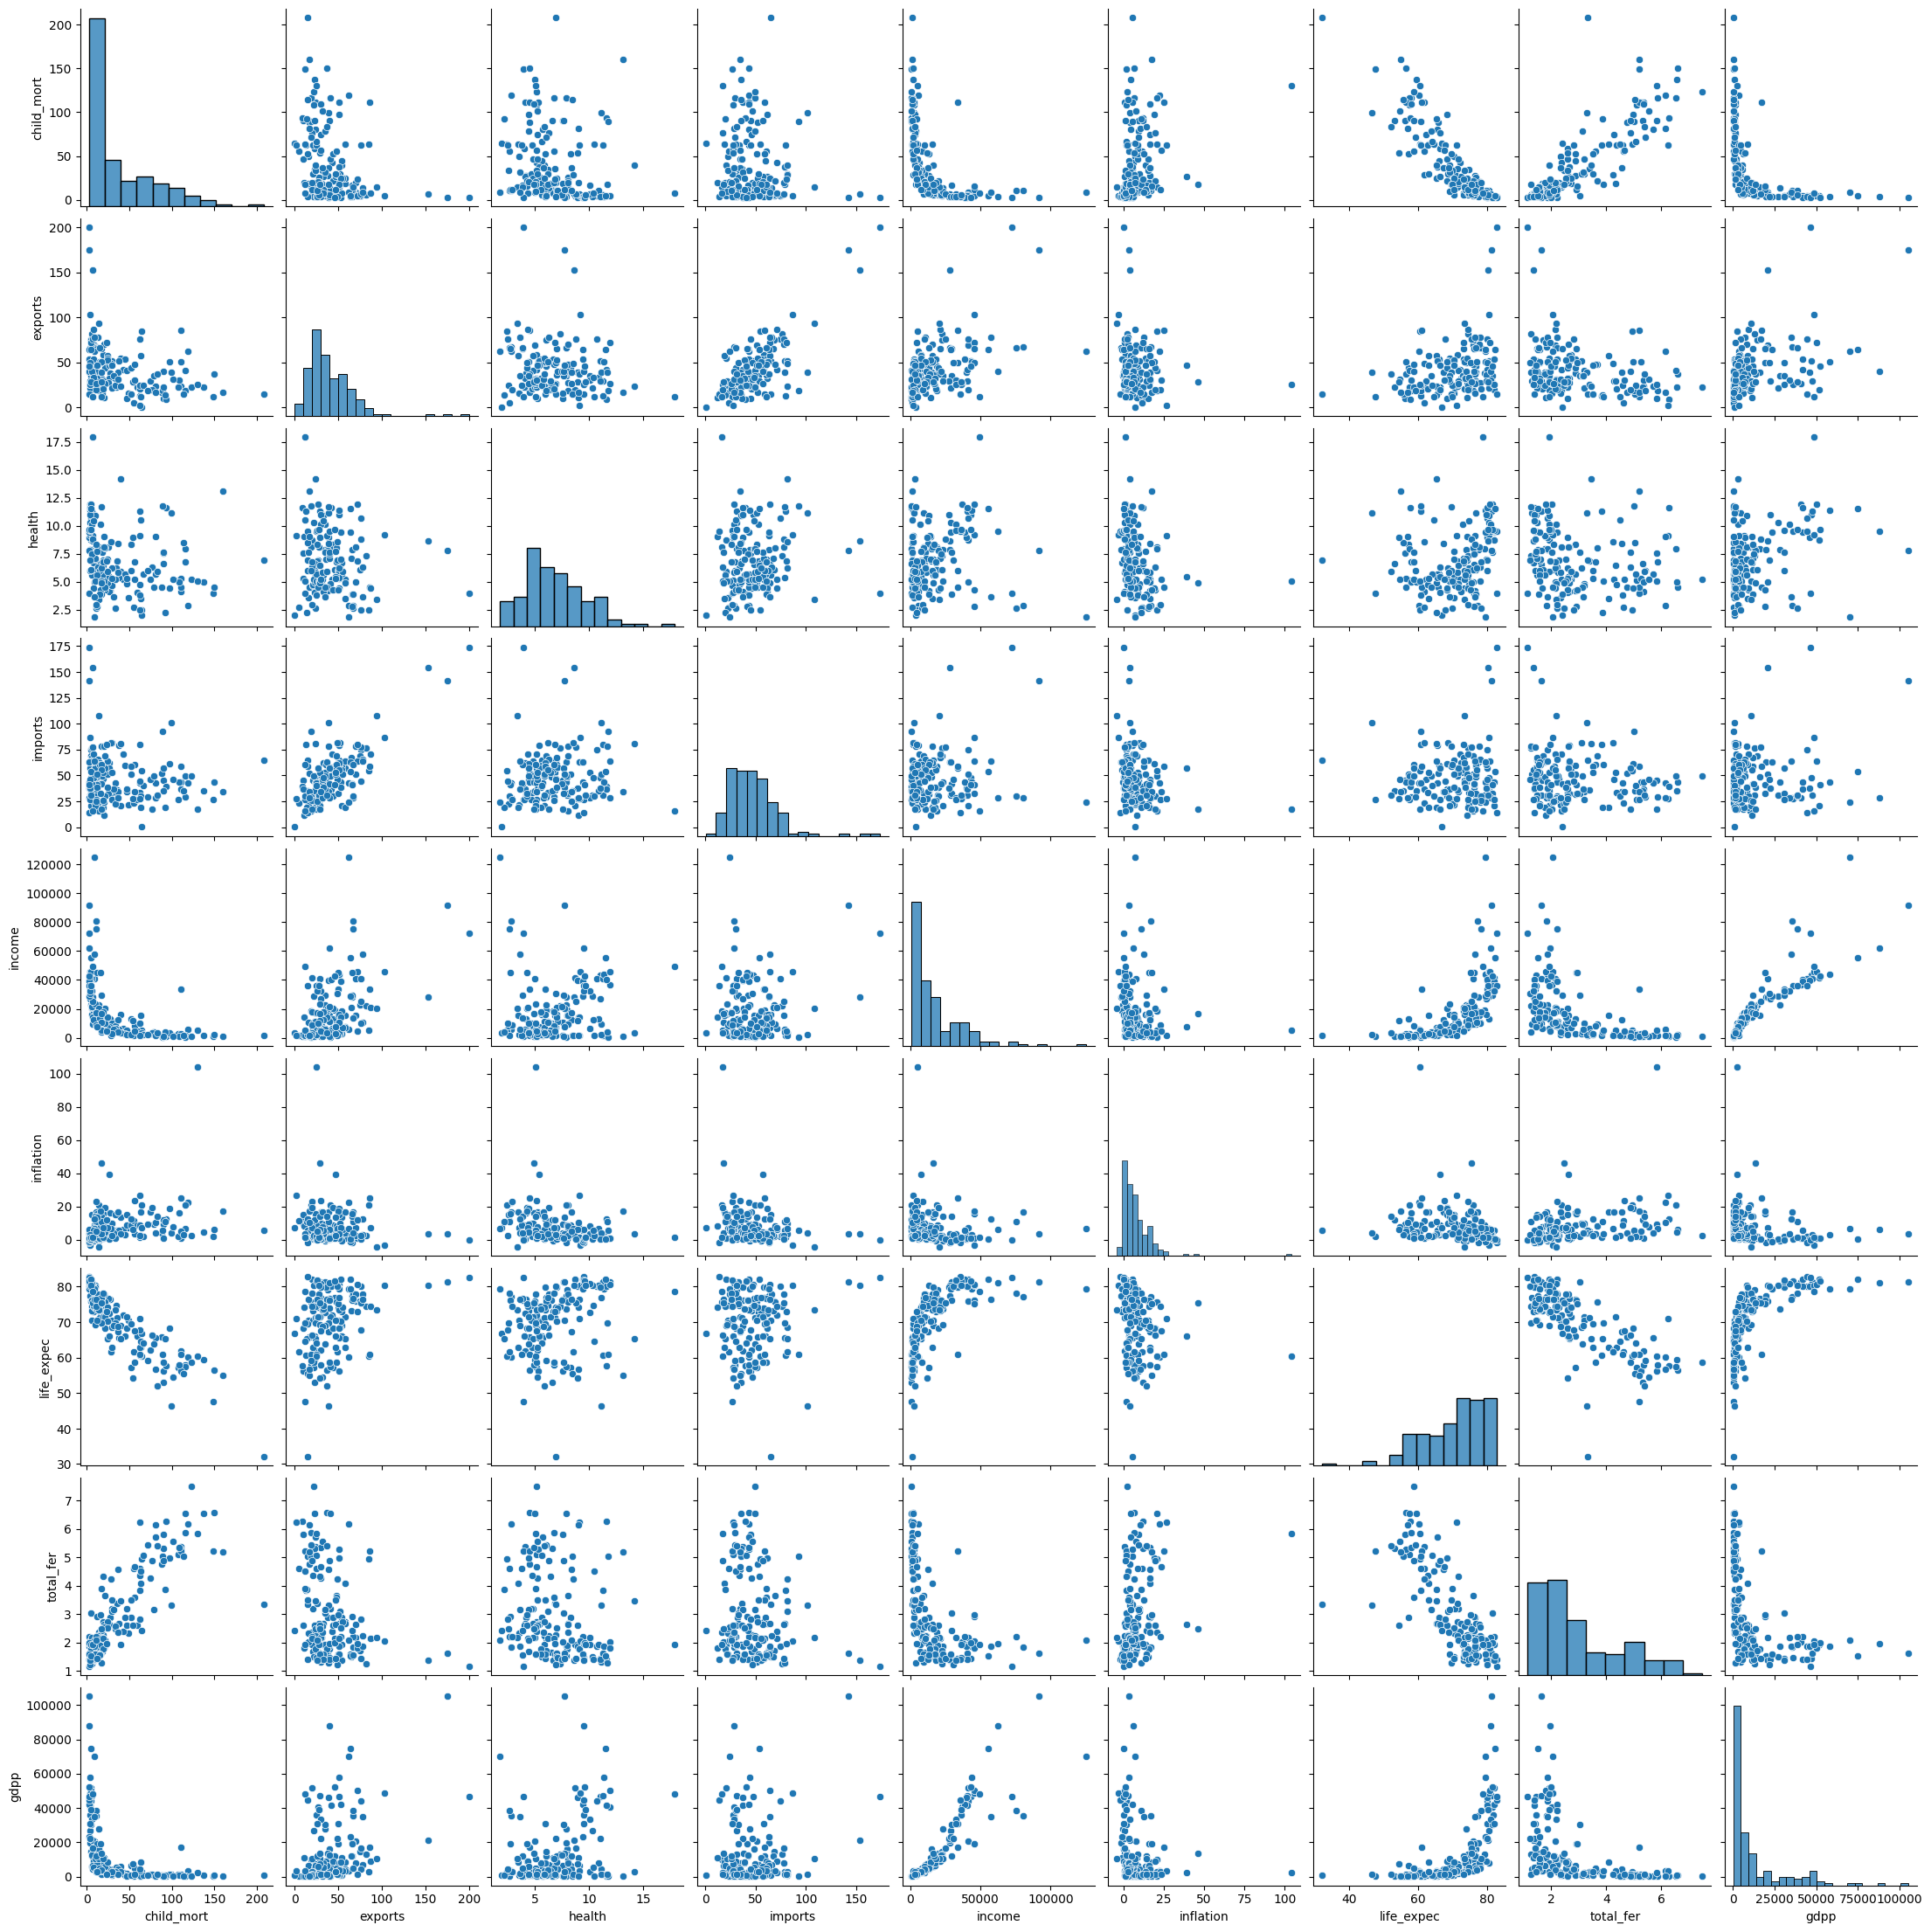

In [34]:
# Pair plot

sns.pairplot(country_df)
# to show
plt.show()

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

In [35]:
# Normalise the data using MinMaxScaler
# Name the normalised dataframe "df_scaled"
scaler = MinMaxScaler()
model = scaler.fit(country_df)
df_scaled = pd.DataFrame(model.transform(country_df), columns=country_df.columns)

df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


## K-Means Clustering

### Selecting K

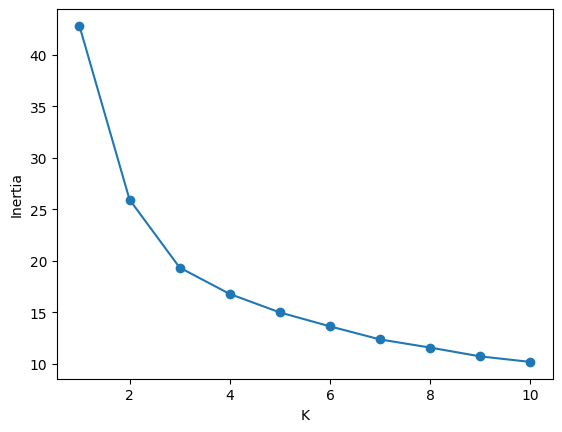

In [36]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show(),
    
elbow_Kmeans(x=df_scaled)

    # Plot elbow curve using scaled dataset

The elbow shows that K=3 will be the optimum number of clusters.

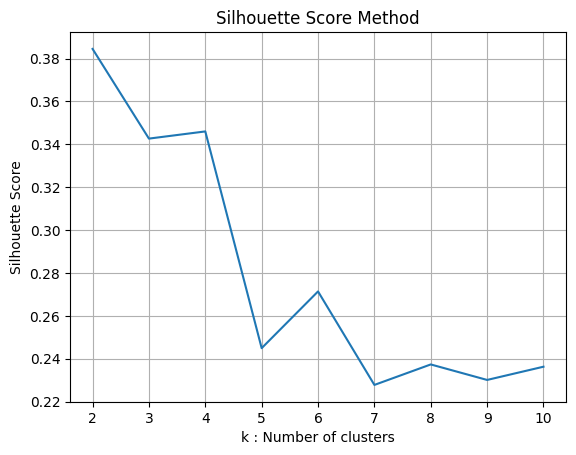

In [37]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()



Based on the elbow and silhouette score method choose a value for K.

## Fitting a K-Means Model with the selected K value

In [38]:
# Fitting k model to scaled data.
kmeans = KMeans(n_clusters=3, random_state=rseed)
kmeans.fit(df_scaled)   

KMeans(n_clusters=3, random_state=42)

In [39]:
# Count the number of records in each cluster
kmeans.labels_
clusterCount = np.bincount(kmeans.labels_)
clusterCount



array([34, 46, 87], dtype=int64)

In [40]:
# Model performance with the silhouette coefficient

score = silhouette_score(df_scaled, kmeans.labels_, metric='euclidean')
score

0.34265474105126204

## Predictions

In [41]:
df_scaled['cluster'] = kmeans.labels_
df_scaled

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073,1
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833,2
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365,2
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488,1
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242,2
...,...,...,...,...,...,...,...,...,...,...
162,0.129503,0.232582,0.213797,0.302609,0.018820,0.063118,0.609467,0.370662,0.026143,2
163,0.070594,0.142032,0.192666,0.100809,0.127750,0.463081,0.854043,0.208202,0.126650,2
164,0.100779,0.359651,0.312617,0.460715,0.031200,0.150725,0.808679,0.126183,0.010299,2
165,0.261441,0.149536,0.209447,0.197397,0.031120,0.257000,0.698225,0.555205,0.010299,1


## Visualisation of clusters

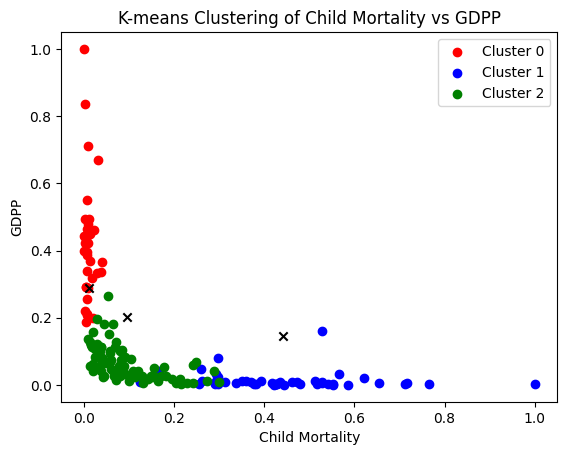

In [42]:
# Visualisation of clusters: child mortality vs gdpp
x = df_scaled[['child_mort','gdpp']].values.reshape(-1,2)
y_pred = df_scaled.cluster
colours = 'rbgcmy'
for c in range(3):
    plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
    plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')
plt.xlabel('Child Mortality')
plt.ylabel('GDPP')
plt.title('K-means Clustering of Child Mortality vs GDPP')
plt.legend()
plt.show()

# Extracted from 'Kmeans.ipynb'

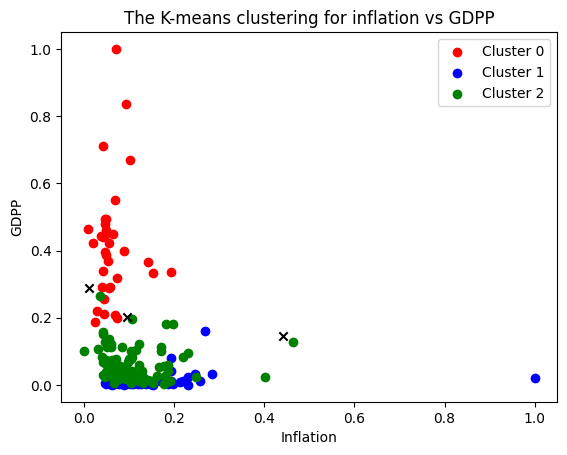

In [43]:
# Visualisation of clusters: inflation vs gdpp
x = df_scaled[['inflation','gdpp']].values.reshape(-1,2)  
y_pred = df_scaled.cluster

colours = 'rbgcmy'
for c in range(3):
    plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
    plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')
        
plt.title('The K-means clustering for inflation vs GDPP')
plt.xlabel('Inflation')
plt.ylabel('GDPP')
plt.legend()
plt.show()


## Conclusions


Based on child mortality, GDPP and inflation; countries belonging to cluster group 1 is the least developed with a high child mortality,low GDPP and low inflation rates. Countries belonging to cluster group 2 are developing countries with an average child mortality, middle level GDPP and an average inflation rate. Countries belong to cluster group 0 are developed countries with a high GDPP, low child mortality and high inflation rate.